<a href="https://colab.research.google.com/github/DommiiUdomp/Dommii/blob/main/eusat_new_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds


In [2]:
ds, info = tfds.load('eurosat', split='train', with_info=True)
image, label = tfds.as_numpy(tfds.load('eurosat', split='train', batch_size=-1, as_supervised=True))

print(type(image), image.shape)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteQ00XUB/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


<class 'numpy.ndarray'> (27000, 64, 64, 3)


In [3]:
label_Dict = dict(zip(np.unique(label), info.features["label"].names))
print(label_Dict)

label_names, label_y = np.unique(label, return_inverse=True)
aa = np.array(np.unique(label_y, return_counts=True)).T
bb = np.array(info.features["label"].names)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


# **Visualize the data**

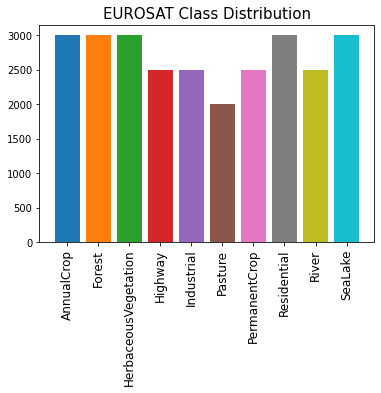

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imshow, subplots, show

fig = plt.plot(figsize = (10,5))
for i in range(len(bb)) :
  xx, hh = aa[i]
  plt.bar(bb[i], hh, align='center')
  plt.xticks(fontsize=12, rotation=90)
  plt.title('EUROSAT Class Distribution', fontsize=15);

plt.show()

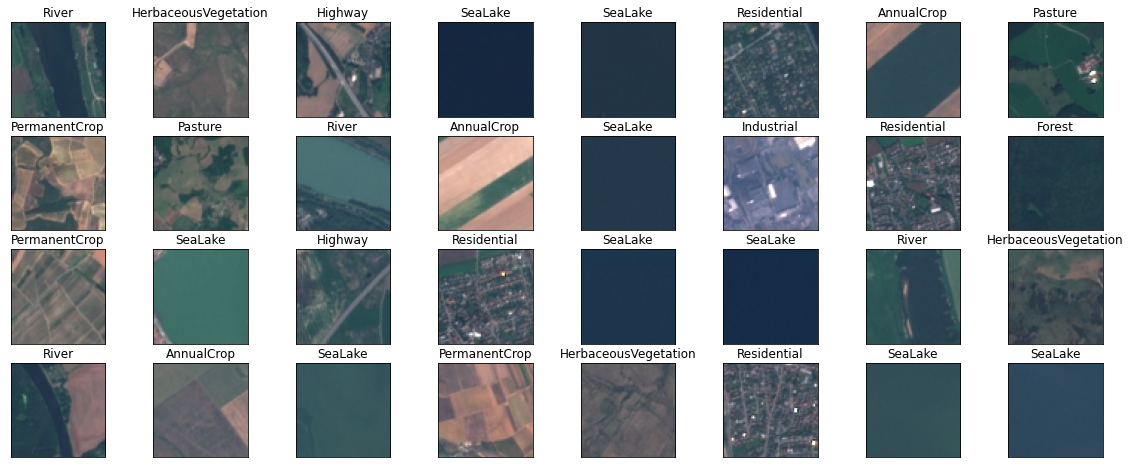

In [5]:
#Plot prepared Data
def random_plot(X,y,C):
  num_test_images = X.shape[0]
  random_inx = np.random.choice(num_test_images, 32)
  random_test_images = X[random_inx, ...]
  random_test_labels = y[random_inx, ...]
  
  plt.figure(figsize=(20, 8))
  for i in range(32):
    plt.subplot(4, 8, i+1, xticks=[], yticks=[])
    if C == 1:
      plt.imshow(random_test_images[i])
    else:
      plt.imshow(random_test_images[i], cmap=plt.cm.gray)
    plt.title(label_Dict[random_test_labels[i]])

  plt.show()

random_plot(image,label, 1)

In [6]:
from sklearn.utils import shuffle

smallest_class = np.argmin(np.bincount(label)) # find the smallest class
print(f' the smallest class: {smallest_class}')

num_classes = len(np.array(np.unique(label))) # number of classes
print(f' the number of classes: {num_classes}')

smallest_class_obs = np.where(label == smallest_class)[0] # observations in smallest class
print(f' observations in smallest class:{smallest_class_obs.shape}')

# Get 2000 observations from each class
indBal = np.empty(0, dtype=int)
for i in range(num_classes):
  indTemp = shuffle(np.where(label == i)[0], random_state=42)[0:smallest_class_obs.shape[0]]
  indBal = np.concatenate([indBal, indTemp])

# shuffle the balanced index
indBal = shuffle(indBal, random_state = 101)

 the smallest class: 5
 the number of classes: 10
 observations in smallest class:(2000,)


In [7]:
#Make dataset balance
label_bal = label[indBal]
image_bal = image[indBal]

print(label_bal.shape)
print(image_bal.shape)

(20000,)
(20000, 64, 64, 3)


In [8]:
#preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

splite = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=101)
print(splite.get_n_splits(image_bal, label_bal))

for train_index, test_index in splite.split(image_bal, label_bal):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = image_bal[train_index], image_bal[test_index]
  y_train, y_test = label_bal[train_index], label_bal[test_index]

1
TRAIN: [13766  8905  5176 ... 12158  1555 10242] TEST: [16086  3312 14479 ... 14168  9997 14857]


In [9]:
from tensorflow.keras.utils import to_categorical

X_train = X_train.astype('float64') # Convert train and test images into 'float64' type
X_test = X_test.astype('float64')
#Normalize the images data #minimum and maximum values equal to 0 and 1 respectively.
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

y_train = y_train.astype('int64') # Convert train and test labels into 'int64' type
y_test = y_test.astype('int64')
# convert class vectors to binary class matrices
y_train_class = to_categorical(y_train, num_classes)
y_test_class = to_categorical(y_test, num_classes)

print(f'Min: {X_train.min()}, Max: {X_train.max()}')
print(f'New_Min: {X_train_scaled.min()}, New_Max: {X_train_scaled.max()}')

Min: 0.0, Max: 255.0
New_Min: 0.0, New_Max: 1.0


In [10]:
#Grey Image
from skimage.color import rgb2gray

#Create an RGB representation of a gray-level image.
# convert RGB arrays to grayscale
X_train_B = np.average(X_train_scaled, axis=-1)
X_test_B = np.average(X_test_scaled, axis=-1)

for i in range(X_train.shape[0]):
  X_train_B[i] = rgb2gray(X_train_scaled[i])

for i in range(X_test_scaled.shape[0]):
  X_test_B[i] = rgb2gray(X_test_scaled[i])

# flatten grayscale arrays
X_train_BW = X_train_B.reshape(X_train_B.shape[0],
                                X_train_B.shape[1] * X_train_B.shape[2])

X_test_BW = X_test_B.reshape(X_test_B.shape[0],
                              X_test_B.shape[1] * X_test_B.shape[2])

print(X_train_BW.shape)
print(X_test_BW.shape)
print(y_train_class.shape)
print(y_test_class.shape)

(14000, 4096)
(6000, 4096)
(14000, 10)
(6000, 10)


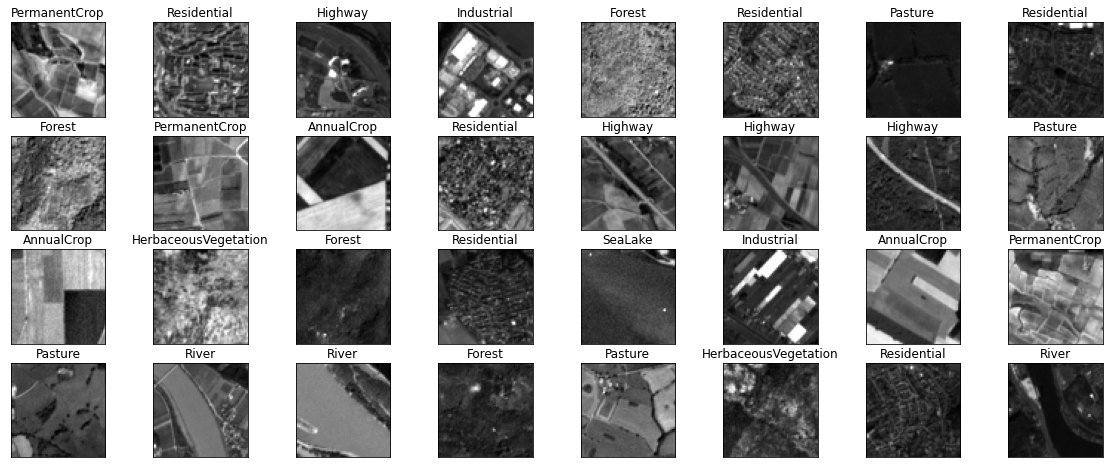

In [11]:
random_plot(X_train_B,y_train, 2)

Highway


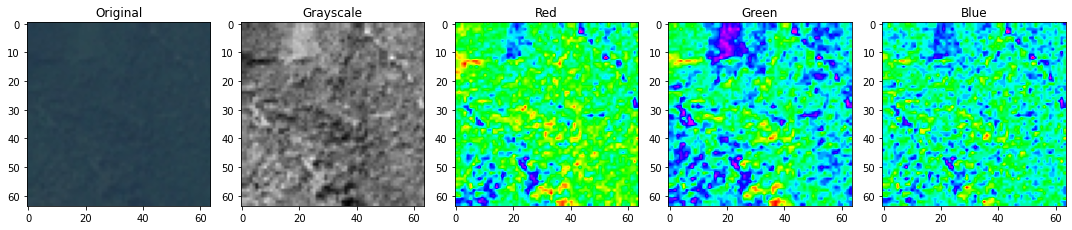

In [12]:
#Plot compare
fig, ax = plt.subplots(1, 5, figsize=(15, 4))

a = np.random.choice(X_train_scaled.shape[0])
ax[0].imshow(X_train_scaled[a])
ax[0].set_title("Original")
ax[1].imshow(X_train_B[a], cmap=plt.cm.gray)
ax[1].set_title("Grayscale")
R = X_train_scaled[a]
ax[2].imshow(R[:,:,0], cmap=plt.cm.hsv)
ax[2].set_title("Red")
ax[3].imshow(R[:,:,1], cmap=plt.cm.hsv)
ax[3].set_title("Green")
ax[4].imshow(R[:,:,2], cmap=plt.cm.hsv)
ax[4].set_title("Blue")

fig.tight_layout()
print(label_Dict[label[a]])
plt.show()

# **Build model**

In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Normalization, Dropout, Input
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model

In [14]:
X_test_BW.shape

(6000, 4096)

In [15]:
from sklearn.model_selection import train_test_split

X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train_BW[...,np.newaxis], y_train_class, stratify = y_train_class, test_size = 0.5, random_state=101)
X_test_1, X_test_2, y_test_1, y_test_2 = train_test_split(X_test_BW[...,np.newaxis], y_test_class, stratify = y_test_class, test_size = 0.5, random_state=101)
print(X_train_1.shape)
print(X_train_2.shape)
print(y_train_1.shape)
print(y_train_2.shape)

(7000, 4096, 1)
(7000, 4096, 1)
(7000, 10)
(7000, 10)


In [16]:
input_shape = X_train_BW[0].shape

# first input model
head_1 = Input(shape=input_shape)
cnn1 = Dense(256, activation='relu')(head_1)
cnn1 = Flatten()(cnn1)

# second input model
head_2 = Input(shape=input_shape)
cnn2 = Dense(128, activation='relu')(head_2)
cnn2 = Flatten()(cnn2)

# merge input models
merge = concatenate([cnn1, cnn2])
dense = Dense(64, activation='relu')(merge)
output = Dense(num_classes, activation='relu')(dense)


model = Model(inputs=[head_1, head_2], outputs=output)
model.compile (optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6) ,
                  loss = tf.keras.losses.CategoricalCrossentropy(), 
                  metrics = [tf.keras.metrics.CategoricalAccuracy()])
model.summary()  

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          1048832     ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          524416      ['input_2[0][0]']                
                                                                                              

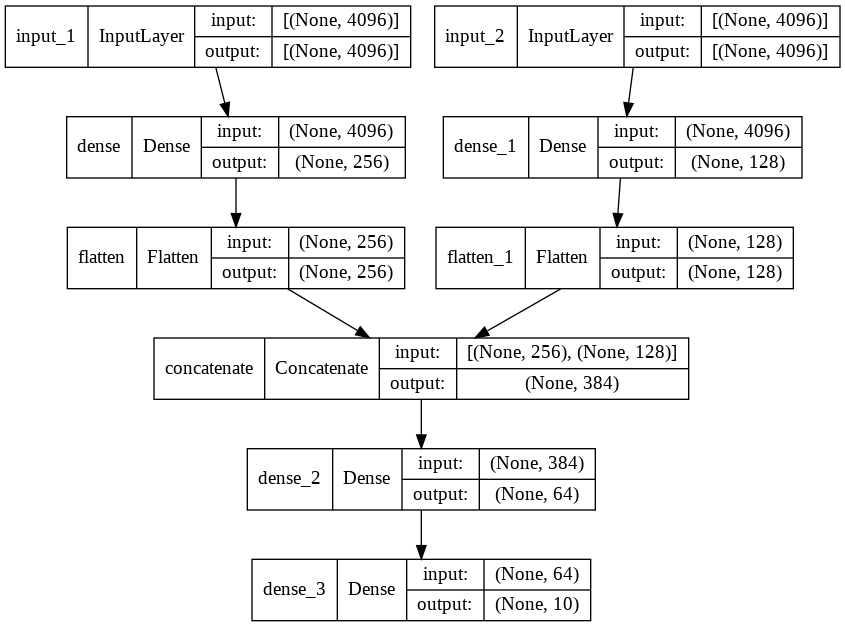

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [18]:
history = model.fit([X_train_1, X_train_2],y_train_1, validation_data= ([X_test_1, X_test_2], y_test_1),
                    batch_size=64 , epochs=100, verbose=1)

score = model.evaluate([X_train_1, X_train_2], y_train_1, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
110/110 [==============================] - 3s 22ms/step - loss: 7.3936 - categorical_accuracy: 0.1174 - val_loss: 6.6664 - val_categorical_accuracy: 0.1250
Epoch 2/100
110/110 [==============================] - 2s 20ms/step - loss: 5.7856 - categorical_accuracy: 0.1374 - val_loss: 4.9554 - val_categorical_accuracy: 0.1320
Epoch 3/100
110/110 [==============================] - 2s 20ms/step - loss: 4.4091 - categorical_accuracy: 0.1423 - val_loss: 4.0331 - val_categorical_accuracy: 0.1327
Epoch 4/100
110/110 [==============================] - 2s 20ms/step - loss: 3.8922 - categorical_accuracy: 0.1409 - val_loss: 3.8462 - val_categorical_accuracy: 0.1330
Epoch 5/100
110/110 [==============================] - 2s 20ms/step - loss: 3.8084 - categorical_accuracy: 0.1411 - val_loss: 3.7947 - val_categorical_accuracy: 0.1343
Epoch 6/100
110/110 [==============================] - 2s 20ms/step - loss: 3.7574 - categorical_accuracy: 0.1427 - val_loss: 3.7632 - val_categorical_accuracy:

In [19]:
def plot_history(model, history) :
  plt.figure(figsize=(10,5))
  ax1 = plt.subplot(121)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss vs. epochs')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training','Validation'],loc='lower left')
  ax2 = plt.subplot(122)
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('Accuracy vs. epochs')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training','Validation'],loc='lower right')
  plt.tight_layout()
  plt.show()

In [20]:
# Define functions for evaluating model accuracy by class and overall

def eval_model_by_class(model, X_test_set, y_test_set):
  y_test_pred = model.predict(X_test_set)
  y_test_pred_tmp=np.argmax(y_test_pred,axis=1)

  y_test_true_tmp = np.argmax(y_test_set, axis = 1)
  label_count = np.unique(y_test_true_tmp, return_counts = True)[1]

  y_test_true = [label_Dict[x] for x in y_test_true_tmp]
  y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

  pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()
  pred_df['label_count'] = label_count
  pred_df['class_acc'] = pred_df.accurate_preds / pred_df.label_count
  pred_df = pred_df.sort_values(by = 'class_acc').reset_index()
  pred_df['overall_acc'] = sum(pred_df.accurate_preds) / sum(pred_df.label_count)
  pred_df = pred_df.sort_values('y_true').reset_index(drop = True)

  return(pred_df)

def find_wrong_preds(model, test_set):
  y_test_pred = model.predict(test_set)
  y_test_pred_tmp=np.argmax(y_test_pred,axis=1)

  y_test_true = [label_Dict[x] for x in y_test_true_tmp]
  y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

  pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
  # pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
  pred_df = pred_df.sort_values('y_true')

  return(pred_df)

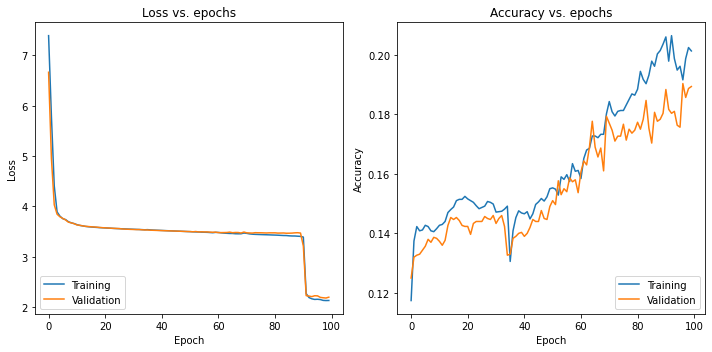

In [21]:
plot_history(model, history)

In [22]:
eval_model_by_class(model, [X_test_1, X_test_2], y_test_1)

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,AnnualCrop,31,300,0.103333,0.189333
1,1,Forest,58,300,0.193333,0.189333
2,2,HerbaceousVegetation,13,300,0.043333,0.189333
3,3,Highway,37,300,0.123333,0.189333
4,4,Industrial,105,300,0.350000,0.189333
5,5,Pasture,41,300,0.136667,0.189333
6,6,PermanentCrop,98,300,0.326667,0.189333
7,7,Residential,36,300,0.120000,0.189333
8,8,River,53,300,0.176667,0.189333
9,9,SeaLake,96,300,0.320000,0.189333


# **Vgg16 model**

In [23]:
from tensorflow.keras.applications import vgg16

conv_base = vgg16.VGG16(include_top=False, weights=None, input_shape = (X_train_scaled[0].shape))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

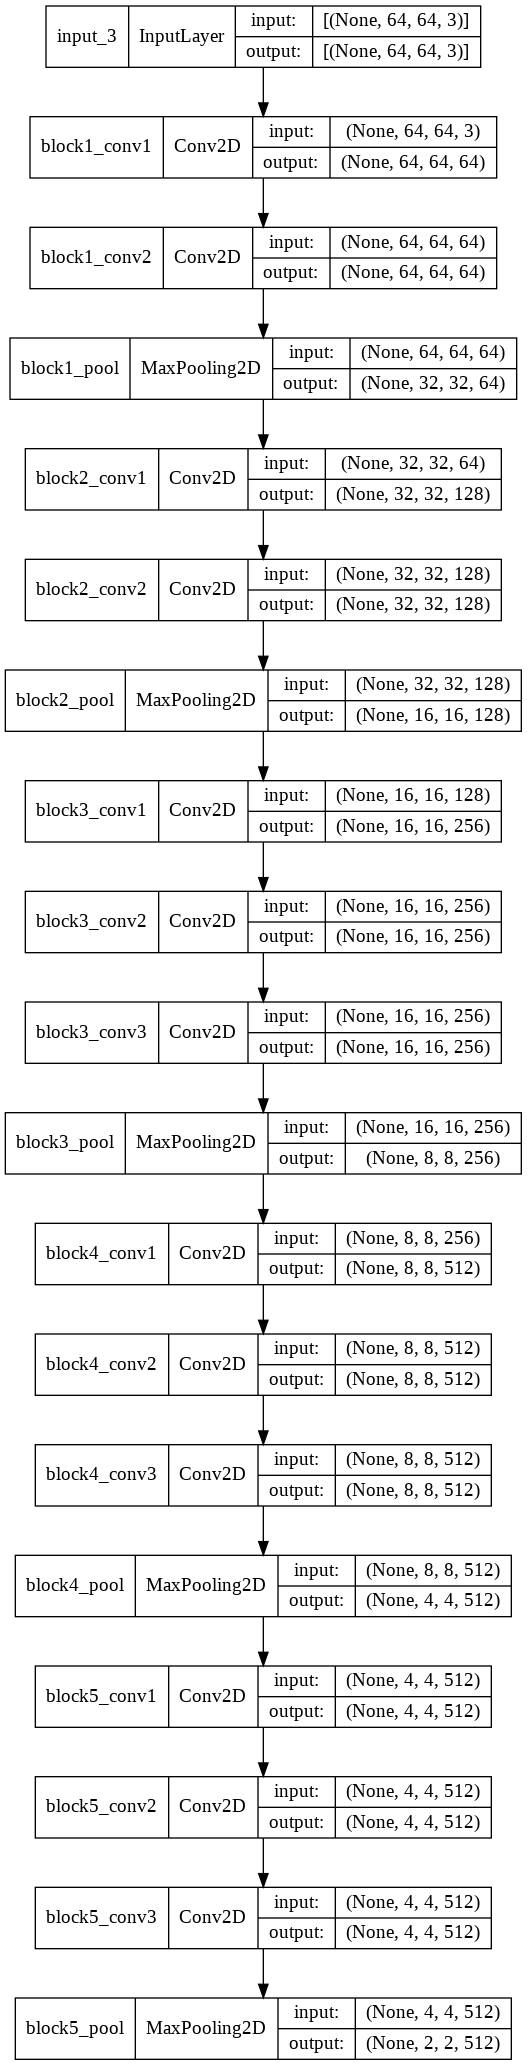

In [24]:
from keras.utils.vis_utils import plot_model
plot_model(conv_base, show_shapes=True, show_layer_names=True)

# **Vgg 19 Model**

In [25]:
from tensorflow.keras.applications import vgg19

conv_basevgg19 = vgg19.VGG19(include_top=False, weights=None, input_shape = (X_train_scaled[0].shape))
conv_basevgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [26]:
from tensorflow.keras.applications import resnet_v2

conv_baseresnet = resnet_v2.ResNet152V2(include_top=False, weights=None, input_shape = (X_train_scaled[0].shape))
conv_baseresnet.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                        